# Render some images

Have some tests for expected intrinsics (in preparation to match w/ real)

In [1]:
from PIL import Image
import numpy as np

from pydrake.all import (
    MakeRenderEngineVtk,
    RenderEngineVtkParams,
    RigidTransform,
    Mesh,
    GeometryId,
    PerceptionProperties,
    RenderLabel,
    RenderCameraCore,
    CameraInfo,
    ClippingRange,
    ColorRenderCamera,
    ImageRgba8U,
)

In [2]:
mesh_file = "sphere_lowpoly.obj"

In [3]:
renderer = MakeRenderEngineVtk(
    RenderEngineVtkParams(
        default_diffuse=[1, 1, 1, 1],
        # default_clear_color=[0, 0, 0],  # Needs binding :(
    ),
)
geometry_id = GeometryId.get_new_id()
perception = PerceptionProperties()
perception.AddProperty("label", "id", RenderLabel(0))
renderer.RegisterVisual(
    geometry_id,
    shape=Mesh(mesh_file),
    properties=perception,
    X_WG=RigidTransform(),
    needs_updates=False,
);

In [4]:
width = 128
height = 128
fov_y = np.pi / 4

core = RenderCameraCore(
    "meh",
    CameraInfo(width, height, fov_y),
    ClippingRange(0.0001, 100.0),
    RigidTransform(),
)
color_camera = ColorRenderCamera(core, False)
# Allocate image.
rgb = ImageRgba8U(width, height)

K = core.intrinsics().intrinsic_matrix()
print(K)

[[154.50966799   0.          63.5       ]
 [  0.         154.50966799  63.5       ]
 [  0.           0.           1.        ]]


[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[  0.   0. -10.]


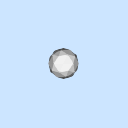

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[  1.   0. -10.]


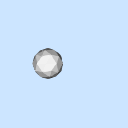

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[  0.   1. -10.]


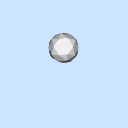

In [5]:
xy_WCs = [
    [0, 0],
    [1, 0],
    [0, 1],
]
for (x, y) in xy_WCs:
    X_WC = RigidTransform([x, y, -10.0])
    R = X_WC.rotation().matrix()
    t = X_WC.translation()
    print(R)
    print(t)
    renderer.UpdateViewpoint(X_WC)
    renderer.RenderColorImage(color_camera, rgb)
    display(Image.fromarray(rgb.data))